In [1]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import hog
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm

%matplotlib inline

## Loading data
This part load pictures path from GTI folders

In [2]:
#load car and non-car pictures
cars = []
notcars = []
car_images_Far = glob.glob('vehicles/GTI_Far/*.png')
car_images_Left = glob.glob('vehicles/GTI_Left/*.png')
car_images_MiddleClose = glob.glob('vehicles/GTI_MiddleClose/*.png')
car_images_Right = glob.glob('vehicles/GTI_Right/*.png')
car_images_KITTI_extracted = glob.glob('vehicles/KITTI_extracted/*.png')
ncar_images_GTI = glob.glob('non-vehicles/GTI/*.png')
ncar_images_Extras = glob.glob('non-vehicles/Extras/*.png')

cars = car_images_Far + car_images_Left + car_images_MiddleClose + \
    car_images_Right + car_images_KITTI_extracted

notcars = ncar_images_GTI + ncar_images_Extras


Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


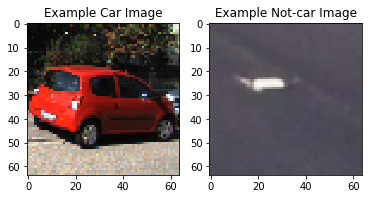

In [3]:

def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_image = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_image.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_image.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')


## Feature Extraction
### 1. Feature Extraction Functions
** Here we define functions for extracting binned color, color hist and HOG features. Those function will be used in feature extraction process. **

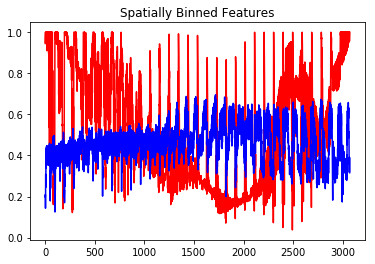

In [4]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Generate a random index to look at a car image
ind_car = np.random.randint(0, len(cars))
# Generate a random index to look at a not-car image
ind_ncar = np.random.randint(0, len(notcars))
# Read in the image
car_image = mpimg.imread(cars[ind_car])
ncar_image = mpimg.imread(notcars[ind_ncar])

car_feature_vec = bin_spatial(car_image,size=(32, 32))
ncar_feature_vec = bin_spatial(ncar_image,size=(32, 32))
# Plot features


plt.plot(car_feature_vec, color = 'red')
plt.plot(ncar_feature_vec, color = 'blue')
plt.title('Spatially Binned Features')



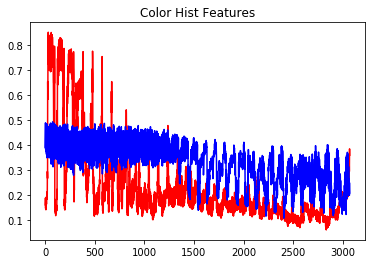

In [5]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Generate a random index to look at a car image
ind_car = np.random.randint(0, len(cars))
# Generate a random index to look at a not-car image
ind_ncar = np.random.randint(0, len(notcars))
# Read in the image
car_image = mpimg.imread(cars[ind_car])
ncar_image = mpimg.imread(notcars[ind_ncar])

car_feature_vec = bin_spatial(car_image,size=(32, 32))
ncar_feature_vec = bin_spatial(ncar_image,size=(32, 32))
# Plot features


plt.plot(car_feature_vec, color = 'red')
plt.plot(ncar_feature_vec, color = 'blue')
plt.title('Color Hist Features')



/home/jasonlan/app/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


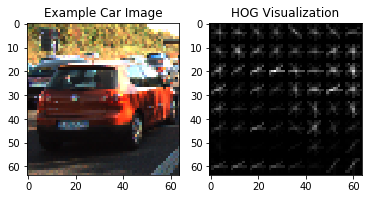

In [6]:
# Define a function to return HOG features and visualization



def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, \
        pixels_per_cell=(pix_per_cell, pix_per_cell), \
        cells_per_block=(cell_per_block, cell_per_block), \
        visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features= hog(img, orientations=orient, \
        pixels_per_cell=(pix_per_cell, pix_per_cell), \
        cells_per_block=(cell_per_block, cell_per_block), \
        visualise=False, feature_vector=feature_vec)
        return features
    
   
   
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
LUV = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
L_channel = LUV[:,:,0]
# Define HOG parameters
orient=8 
pix_per_cell=8
cell_per_block=2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(L_channel, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap = 'gray')
plt.title('HOG Visualization')

### 2. Feature Extraction
** Here I define the process function that extracts all features using functions defined before **

In [7]:
# Define a function to extract image features from a image
# Have this function call bin_spatial() and color_hist()
def image_extract_features(img, cspace, orient, pix_per_cell, cell_per_block,\
                           hog_channel, spatial_size, hist_bins, hist_bins_range,\
                           bin_spatial_f, color_hist_f, hog_f):
    # Create a list to append feature vectors to
    image_features = []
    image = img.copy()
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)  
    # if bin_spatial_f is True, call bin_spatial() function

    if bin_spatial_f == True:
        # Apply bin_spatial() to get spatial color features
        bin_spatial_features = bin_spatial(feature_image, spatial_size)
        # Append to features list
        image_features.append(bin_spatial_features)
    # if color_hist_f is True, call color_hist() function    
    if color_hist_f == True:
        # Apply color_hist() also with a color space option now
        color_hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_bins_range)
        image_features.append(color_hist_features)
    # if hog_f is True, call get_hog_features() to according channel
    if hog_f == True:
        # Call get_hog_features() with vis=False, feature_vec=True
        # If hog_channel is 'ALL' get all the channel's information
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features) 
        # else get specified channel features
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        image_features.append(hog_features)
    return image_features

# Define a function to extract features from a list of image paths calling image_extract_features() defined above
def file_extration_features(imgs_list, cspace='RGB', orient=9,\
                            pix_per_cell=8, cell_per_block=2,\
                            hog_channel='ALL', spatial_size = (32,32),\
                            hist_bins = 32, hist_bins_range = (0, 256),\
                            bin_spatial_f = True,\
                            color_hist_f = True,hog_f = True, flip_aug = True):
    # Define a empty list to hold all the image features
    all_features = [] 
    # Iterate through all the image path and extract all the features
    for image_path in imgs_list:
        image = mpimg.imread(image_path)
        image_features = image_extract_features(image, cspace=cspace, orient=orient,\
                                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,\
                                                hog_channel=hog_channel, spatial_size = spatial_size,\
                                                hist_bins = hist_bins, hist_bins_range = hist_bins_range,\
                                                bin_spatial_f = bin_spatial_f,\
                                                color_hist_f = color_hist_f,\
                                                hog_f = hog_f)
        all_features.append(np.concatenate(image_features))
        # If flip_aug is True, doing image augmentation by flipping the image and append to all_features
        if flip_aug == True:
            # Flip the original pitcure to augment the training data
            image_aug = np.fliplr(image)
            image_features_aug = image_extract_features(image_aug, cspace=cspace, orient=orient,\
                                                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,\
                                                        hog_channel=hog_channel, spatial_size = spatial_size,\
                                                        hist_bins = hist_bins, hist_bins_range = hist_bins_range,\
                                                        bin_spatial_f = bin_spatial_f,\
                                                        color_hist_f = color_hist_f,\
                                                        hog_f = hog_f)
            all_features.append(np.concatenate(image_features_aug))
    
    return all_features
            

## Trainining Classifier
** This part is for trainging the Classifier **


### 1. Preparing Data

In [8]:
cspace='LUV'
orient=8 
pix_per_cell=8
cell_per_block=2
hog_channel=0
spatial_size = (16,16)
hist_bins = 32
hist_bins_range = (0, 256)
bin_spatial_f = True
color_hist_f = True
hog_f = True
flip_aug = True

# cars_features = file_extration_features(cars, cspace=cspace, orient=orient, pix_per_cell=pix_per_cell, \
#                                        cell_per_block=cell_per_block, hog_channel=hog_channel, \
#                                        spatial_size = spatial_size, hist_bins = hist_bins, \
#                                        hist_bins_range = hist_bins_range, bin_spatial_f = True,\
#                                        color_hist_f = True, hog_f = True, flip_aug = True)
# print("There are totally: ", len(cars)  + len(cars) * flip_aug, "car images")
# print("Extracted", len(cars_features))

# notcars_features = file_extration_features(notcars, cspace=cspace, orient=orient, pix_per_cell=pix_per_cell, \
#                                        cell_per_block=cell_per_block, hog_channel=hog_channel, \
#                                        spatial_size = spatial_size, hist_bins = hist_bins, \
#                                        hist_bins_range = hist_bins_range, bin_spatial_f = True,\
#                                        color_hist_f = True, hog_f = True, flip_aug = True)
# print("There are totally: ", len(notcars)  + len(notcars) * flip_aug, "notcar images")
# print("Extracted", len(notcars_features))


** Creating labels for the data set and combine **

In [9]:
# y = np.hstack((np.ones(len(cars_features)), np.zeros(len(notcars_features))))
# X = np.vstack((cars_features, notcars_features)).astype(np.float64)

** Normalizing features **

In [10]:
# X_scaler = StandardScaler().fit(X)
# scaled_X = X_scaler.transform(X)

In [11]:
import pickle
# with open('scaler.pkl', 'wb') as f:
#     pickle.dump(X_scaler, f)
    
with open('scaler.pkl', 'rb') as f:
    X_scaler = pickle.load(f)

** Spliting training and testing data **

In [12]:
# rand_state = np.random.randint(0,200)
# X_train, X_test, y_train, y_test= train_test_split(scaled_X, y,test_size=0.2, random_state=rand_state)

### 2. Parameter Tuning

In [13]:
# # Define tuning parameters
# parameters = {'kernel':('linear', 'rgb'), 'C':[x for x in np.linspace(0.1, 10, 3)]}
# # Use GridSearchCV to pick best parameters
# svr = svm.SVC()
# clf =  GridSearchCV(svr, parameters)
# clf.fit(X_train, y_train)


### 3. Training Classifier
** This part is using the tuned parameter to train the SVM classifier **

In [14]:
# import time
# print("Parameter Setting:")
# print("    Orientations: ", orient)
# print("    pixels per cell: ",pix_per_cell)
# print("    cells per block: ",cell_per_block)
# print("    hog channel: ",hog_channel)
# print("    spatial size: ",spatial_size)
# print("    hist bins: ",hist_bins)
# print('Feature number:', len(X_train[0]))
# svc = svm.SVC(kernel='rbf', C= 1) # Use a linear SVC 
# t=time.time() # Check the training time for the SVC
# svc.fit(X_train, y_train) # Train the classifier
# t2 = time.time()
# print(round(t2-t, 2), 'Seconds to train classifier')
# print('Test Accuracy of Classifier = ', round(svc.score(X_test, y_test), 4))

In [15]:
import pickle
# save model
# with open('svm_model.pkl', 'wb') as f:
#     pickle.dump(svc, f)
    
with open('svm_model.pkl', 'rb') as f:
    svc = pickle.load(f)

## Sliding Windows
*This part I majorly use the function in Udacity courses*

In [16]:
# This Function takes an image, a list of bounding boxes, 
# and optional color tuple and line thickness as inputs
# then draws boxes in that color on the output
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched 
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            window_list.append(((startx, starty), (endx, endy)))
    
    return window_list

In [17]:
# Search function that takes an image 
# and the list of windows to be searched (output of slide_windows())
# Return the windows that found cars
def search_windows(img, windows, clf, scaler, color_space='RGB', \
                   spatial_size=(32, 32), hist_bins=32, \
                   hist_range=(0, 256), orient=9, \
                   pix_per_cell=8, cell_per_block=2, \
                   hog_channel=0, spatial_feat=True, \
                   hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    img = img.copy()
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))

        
        #4) Extract features for that window using single_img_features()
        features = image_extract_features(test_img, cspace=color_space, orient = orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,\
                           hog_channel=hog_channel, spatial_size=spatial_size, hist_bins=hist_bins, hist_bins_range = (0, 256),\
                           bin_spatial_f=spatial_feat, color_hist_f=hist_feat, hog_f=hog_feat)

        #5) Scale extracted features to be fed to classifier
        features = ((np.concatenate(features)).astype(np.float64)).reshape(1,-1)
#         print(features)
#         print("...................")
        test_features = scaler.transform(features)
#         print(test_features)
#         print(">>>>>>>>>>>>>>>>>>>")

        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

** Test on test picutres (search_windows() function) ** 

/home/jasonlan/app/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


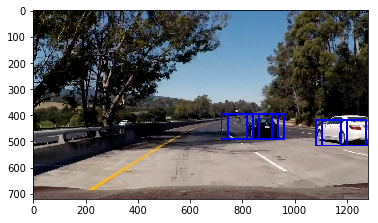

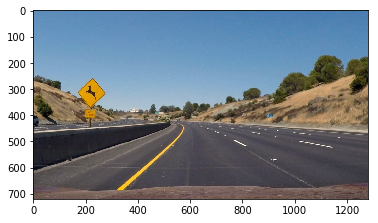

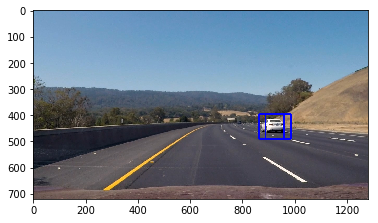

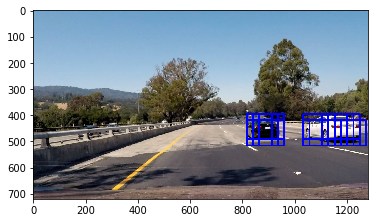

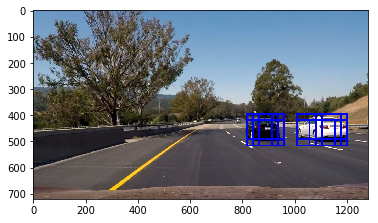

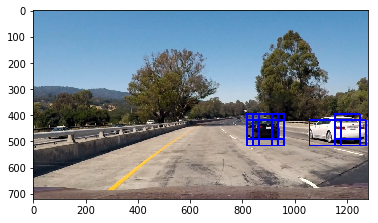

In [18]:
cspace='LUV'
orient=8 
pix_per_cell=8
cell_per_block=2
hog_channel=0
spatial_size = (16,16)
hist_bins = 32
hist_bins_range = (0, 256)
bin_spatial_f = True
color_hist_f = True
hog_f = True

test_image_names = glob.glob("test_images/*.jpg")

for image_name in test_image_names:
    image = mpimg.imread(image_name)
    image = (image/255.).astype(np.float32)
    y_start_stop = [300, 700]
    draw_image = mpimg.imread(image_name)
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(96, 96), xy_overlap=(0.75, 0.75))


    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=cspace, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=bin_spatial_f, 
                            hist_feat=color_hist_f, hog_feat=hog_f)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)   
    plot = plt.imshow(window_img)
    plt.show()







** window scale and position exploration **

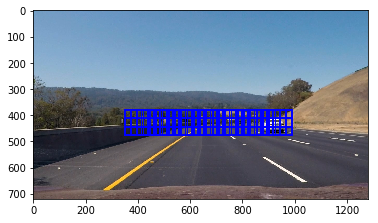

In [19]:

image = mpimg.imread("test_images/test3.jpg")
x_start_stop = [350,1000 ]
y_start_stop = [380, 476]
windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                        xy_window=(64, 64), xy_overlap=(5/8, 0.5))
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)
plt.imshow(window_img)

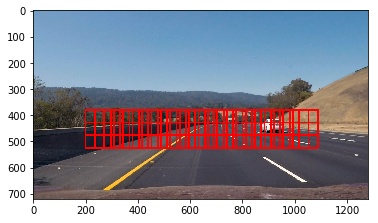

In [20]:
image = mpimg.imread("test_images/test3.jpg")
x_start_stop = [200,1100]
y_start_stop = [380, 524]
windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                        xy_window=(96, 96), xy_overlap=(5/8, 4/8))
window_img = draw_boxes(image, windows, color=(255, 0, 0), thick=6)
plt.imshow(window_img)

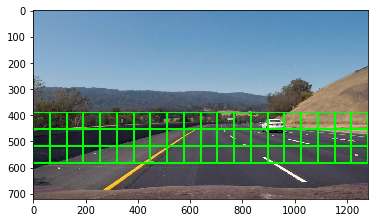

In [21]:
image = mpimg.imread("test_images/test3.jpg")
x_start_stop = [0,1280]
y_start_stop = [390, 582]
windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                        xy_window=(128, 128), xy_overlap=(0.5, 0.5))
window_img = draw_boxes(image, windows, color=(0, 255, 0), thick=6)
plt.imshow(window_img)

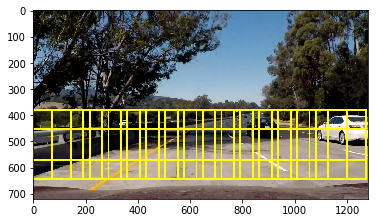

In [22]:
image = mpimg.imread("test_images/test5.jpg")
x_start_stop = [0,1280]
y_start_stop = [380, 668]
windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                        xy_window=(192, 192), xy_overlap=(5/8, 5/8))
window_img = draw_boxes(image, windows, color=(255, 255, 0), thick=6)
plt.imshow(window_img)

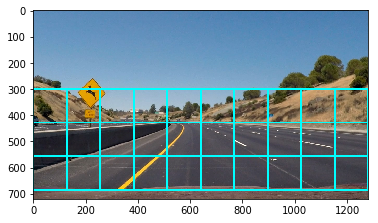

In [23]:
image = mpimg.imread("test_images/test2.jpg")
x_start_stop = [0,1280 ]
y_start_stop = [300, 720]
windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                        xy_window=(256, 256), xy_overlap=(4/8, 4/8))
window_img = draw_boxes(image, windows, color=(0, 255, 255), thick=6)
plt.imshow(window_img)

** Test new windows **


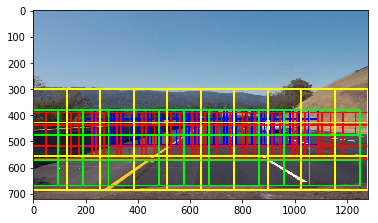

In [24]:
total_windows = []
image = mpimg.imread("test_images/test3.jpg")

x_start_stop = [350,1000 ]
y_start_stop = [380, 476]
windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                        xy_window=(64, 64), xy_overlap=(0.5, 0.5))
window_img = draw_boxes(image, windows, color=(0, 255, 255), thick=6)

x_start_stop = [200,1100]
y_start_stop = [380, 524]
windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                        xy_window=(96, 96), xy_overlap=(5/8, 5/8))
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)


x_start_stop = [0,1280]
y_start_stop = [390, 582]
windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                        xy_window=(128, 128), xy_overlap=(5/8, 5/8))
window_img = draw_boxes(window_img, windows, color=(255, 0, 0), thick=6)

x_start_stop = [0,1280]
y_start_stop = [380, 668]
windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                        xy_window=(192, 192), xy_overlap=(0.5, 0.5))
window_img = draw_boxes(window_img, windows, color=(0, 255, 0), thick=6)

x_start_stop = [0,1280 ]
y_start_stop = [300, 720]
windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                        xy_window=(256, 256), xy_overlap=(4/8, 4/8))
window_img = draw_boxes(window_img, windows, color=(255, 255, 0), thick=6)

plt.imshow(window_img)





/home/jasonlan/app/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


It takes  2.004722833633423 s to process a frame


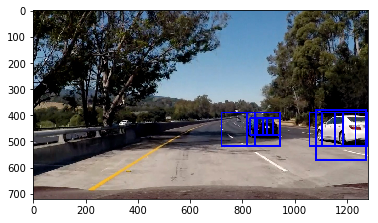

It takes  1.9448292255401611 s to process a frame


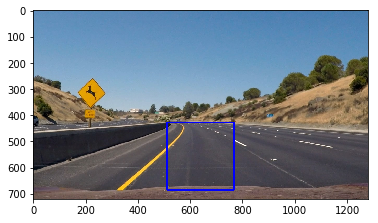

It takes  1.9720823764801025 s to process a frame


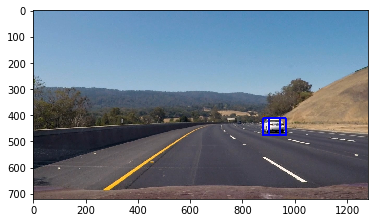

It takes  1.9560222625732422 s to process a frame


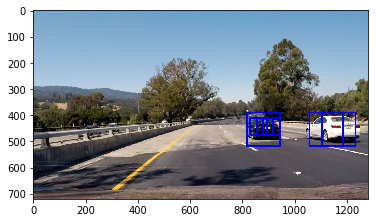

It takes  1.9697186946868896 s to process a frame


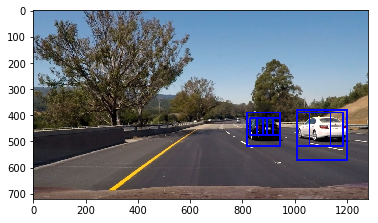

It takes  1.9662461280822754 s to process a frame


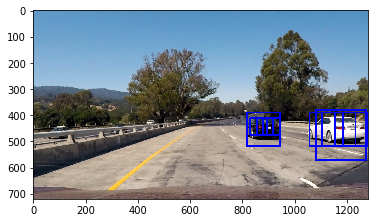

In [25]:
cspace='LUV'
orient=8 
pix_per_cell=8
cell_per_block=2
hog_channel=0
spatial_size = (16,16)
hist_bins = 32
hist_bins_range = (0, 256)
bin_spatial_f = True
color_hist_f = True
hog_f = True
import time
test_image_names = glob.glob("test_images/*.jpg")
t = time.time() 
for image_name in test_image_names:
    t1 = time.time()
    windows = []
    image = mpimg.imread(image_name)
    image = (image/255.).astype(np.float32)
    
    draw_image = mpimg.imread(image_name)
    x_start_stop = [350,1000 ]
    y_start_stop = [380, 476]
    windows += slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                        xy_window=(64, 64), xy_overlap=(5/8, 0.5))
    
#     x_start_stop = [200,1100]
#     y_start_stop = [380, 524]
#     windows += slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
#                         xy_window=(96, 96), xy_overlap=(4/8, 5/8)) 


    x_start_stop = [0,1280]
    y_start_stop = [390, 582]
    windows += slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                        xy_window=(128, 128), xy_overlap=(5/8, 4/8))
    
    x_start_stop = [0,1280]
    y_start_stop = [380, 668]
    windows += slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                        xy_window=(192, 192), xy_overlap=(5/8, 4/8))
    
    x_start_stop = [0,1280 ]
    y_start_stop = [300, 720]
    windows += slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                        xy_window=(256, 256), xy_overlap=(4/8, 4/8))
    
    
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=cspace, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=bin_spatial_f, 
                            hist_feat=color_hist_f, hog_feat=hog_f)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)   
    t2 = time.time()
    print("It takes ", t2-t1, "s to process a frame")
    plot = plt.imshow(window_img)
    plt.show()
    


** False positive screening **

In [26]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


/home/jasonlan/app/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


It takes  1.7371480464935303 s to process a frame


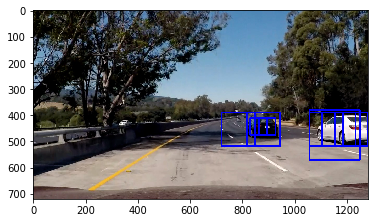

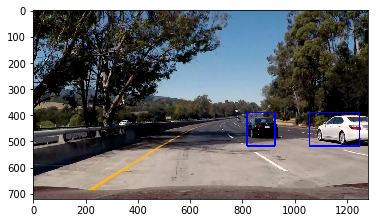

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
It takes  1.7243626117706299 s to process a frame


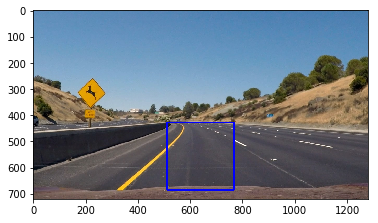

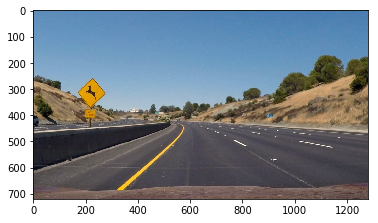

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
It takes  1.746952772140503 s to process a frame


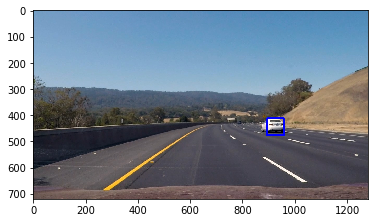

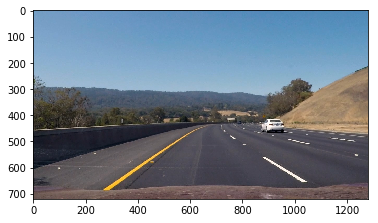

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
It takes  1.7190420627593994 s to process a frame


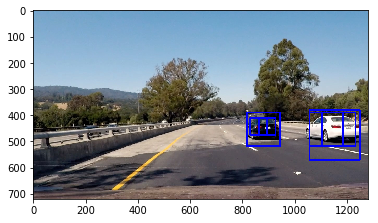

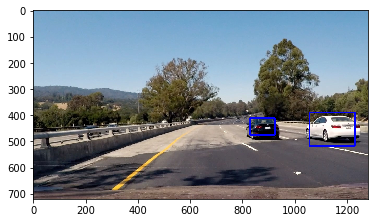

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
It takes  1.7197749614715576 s to process a frame


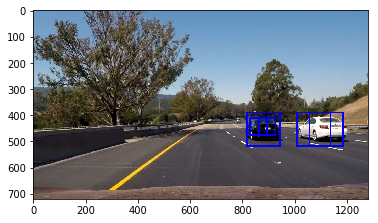

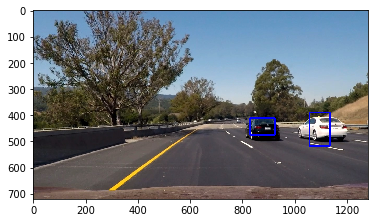

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
It takes  1.7379040718078613 s to process a frame


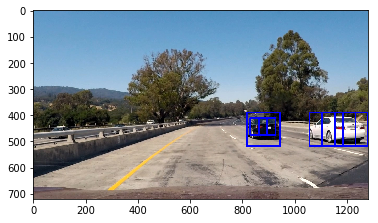

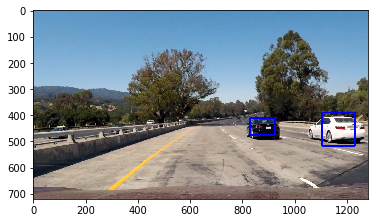

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


In [27]:
cspace='LUV'
orient=8 
pix_per_cell=8
cell_per_block=2
hog_channel=0
spatial_size = (16,16)
hist_bins = 32
hist_bins_range = (0, 256)
bin_spatial_f = True
color_hist_f = True
hog_f = True
import time
test_image_names = glob.glob("test_images/*.jpg")
t = time.time() 
for image_name in test_image_names:
    t1 = time.time()
    windows = []
    image_org = mpimg.imread(image_name)
    heat = np.zeros_like(image_org[:,:,0]).astype(np.float)
    image = (image_org/255.).astype(np.float32)
    
    draw_image = mpimg.imread(image_name)
    x_start_stop = [350,1000 ]
    y_start_stop = [380, 476]
    windows += slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                        xy_window=(64, 64), xy_overlap=(0.5, 0.5))
    
#     x_start_stop = [200,1100]
#     y_start_stop = [380, 524]
#     windows += slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
#                         xy_window=(96, 96), xy_overlap=(4/8, 4/8)) 


    x_start_stop = [0,1280]
    y_start_stop = [390, 582]
    windows += slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                        xy_window=(128, 128), xy_overlap=(5/8, 5/8))
    
    x_start_stop = [0,1280]
    y_start_stop = [380, 668]
    windows += slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                        xy_window=(192, 192), xy_overlap=(0.5, 0.5))
    
    x_start_stop = [0,1280 ]
    y_start_stop = [300, 720]
    windows += slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                        xy_window=(256, 256), xy_overlap=(4/8, 4/8))
    
    
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=cspace, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=bin_spatial_f, 
                            hist_feat=color_hist_f, hog_feat=hog_f)                       
    
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
    draw_img = draw_labeled_bboxes(np.copy(image_org), labels)
    t2 = time.time()
    print("It takes ", t2-t1, "s to process a frame")
    plot = plt.imshow(window_img)
    plt.show()
    plot = plt.imshow(draw_img)
    plt.show()
    print("<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")

In [28]:
def draw_boxes(img, bboxes, thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], bbox[2], thick)
    # Return the image copy with boxes drawn
    return imcopy

# Function that contains color space converting
def convert_color(img, cspace='LUV'):
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)  
    return feature_image


# Function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, cspace, spatial_size, hist_bins, hog_channel,\
             box_color = (0,0,255), cells_per_step = 4):
    hot_windows = []
    draw_img = np.copy(img)
    image = img.copy()
#     img = (img/255.).astype(np.float32)

    
    img_tosearch = image[ystart:ystop,:,:]


    ctrans_tosearch = convert_color(img_tosearch, cspace=cspace)


    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1

    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_list = []
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_list.append(hog_feat1)
            hog_list.append(hog_feat2)
            hog_list.append(hog_feat3)
            if hog_channel == 'ALL':
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = np.array(hog_list[hog_channel])

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)

            hist_features = color_hist(subimg, nbins=hist_bins)

            features = np.concatenate((spatial_features, hist_features, hog_features)).reshape(1, -1)
            # Scale features and make a prediction
            test_features = X_scaler.transform(features)    

            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))   

            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
                hot_windows.append(((xbox_left, ytop_draw + ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),box_color))
    return hot_windows

/home/jasonlan/app/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


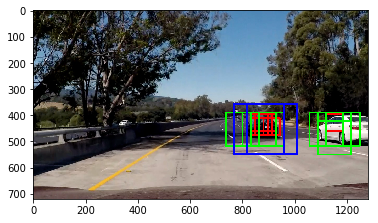

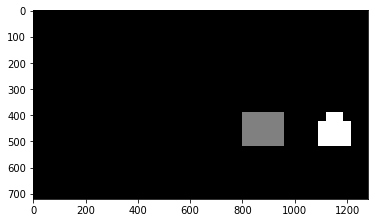

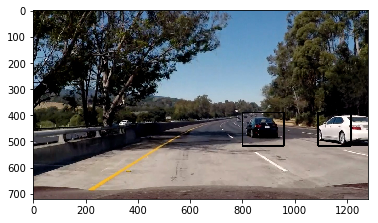

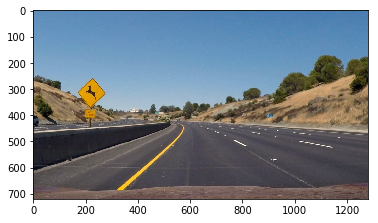

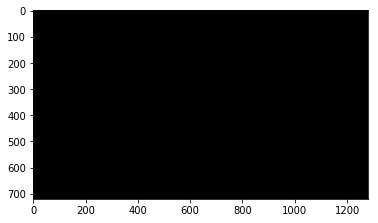

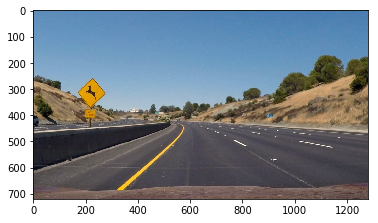

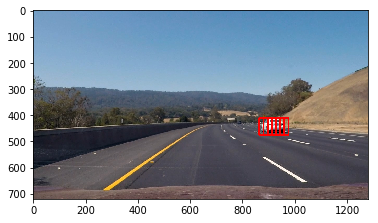

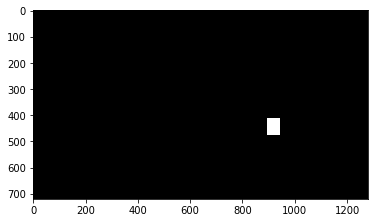

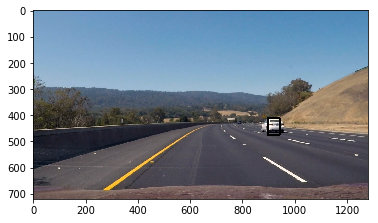

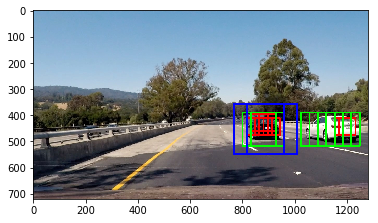

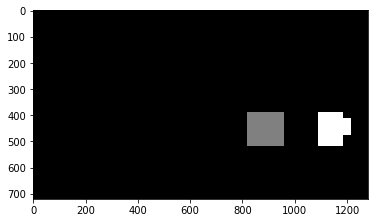

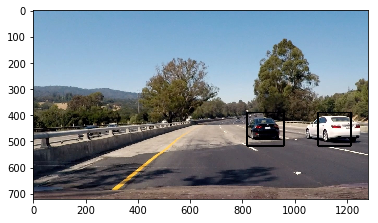

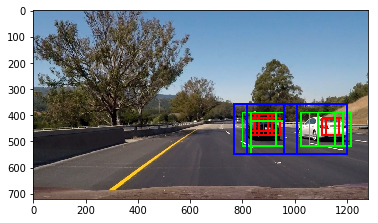

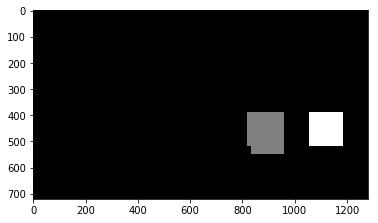

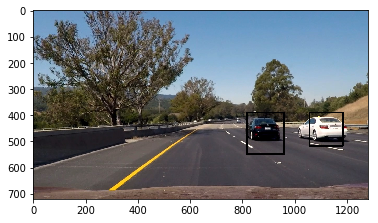

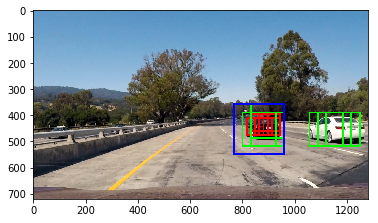

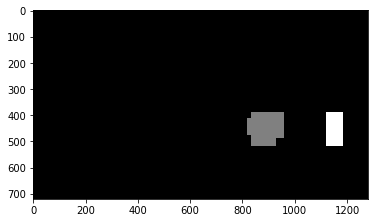

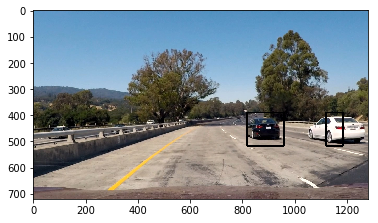

In [35]:
for image_name in glob.glob("test_images/*.jpg"):
    image = mpimg.imread(image_name)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    draw_image = image.copy()
    image = (image/255.).astype(np.float32)



    hot_windows64 = find_cars(image, ystart = 380, ystop = 500, scale = 1, svc = svc, box_color = (255,0,0), X_scaler = X_scaler, orient = orient, pix_per_cell = pix_per_cell,\
                            cell_per_block = cell_per_block, cspace = cspace, spatial_size = spatial_size, hist_bins = hist_bins,\
                            hog_channel = hog_channel, cells_per_step = 2)

    hot_windows128 = find_cars(image, ystart = 358, ystop = 582, scale = 2, svc = svc, box_color = (0,255,0), X_scaler = X_scaler, orient = orient, pix_per_cell = pix_per_cell,\
                            cell_per_block = cell_per_block, cspace = cspace, spatial_size = spatial_size, hist_bins = hist_bins,\
                            hog_channel = hog_channel, cells_per_step = 2)

    hot_windows192 = find_cars(image, ystart = 357, ystop = 668, scale = 3, svc = svc, box_color = (0,0,255), X_scaler = X_scaler, orient = orient, pix_per_cell = pix_per_cell,\
                            cell_per_block = cell_per_block, cspace = cspace, spatial_size = spatial_size, hist_bins = hist_bins,\
                            hog_channel = hog_channel, cells_per_step = 2)

    hot_windows256 = find_cars(image, ystart = 300, ystop = 720, scale = 4, svc = svc, box_color = (0,255,255), X_scaler = X_scaler, orient = orient, pix_per_cell = pix_per_cell,\
                            cell_per_block = cell_per_block, cspace = cspace, spatial_size = spatial_size, hist_bins = hist_bins,\
                            hog_channel = hog_channel, cells_per_step =2)


    hot_windows = hot_windows64 + hot_windows128 + hot_windows192 + hot_windows256

    window_img1 = draw_boxes(draw_image, hot_windows, thick=6)    
    plot = plt.imshow(window_img1)
    plt.show()
    
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)
    

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    plot = plt.imshow(labels[0], cmap = 'gray' )
    plt.show()
    
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    plot = plt.imshow(draw_img)
    plt.show()

/home/jasonlan/app/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


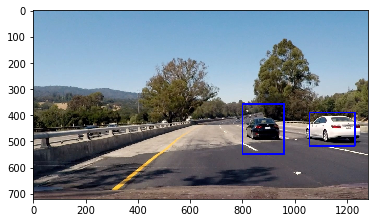

In [30]:
def pipeline_vehicle_detection(image):
    ori_image = image
    image = (image/255.).astype(np.float32)

    hot_windows64 = find_cars(image, ystart = 380, ystop = 500, scale = 1, svc = svc, box_color = (255,0,0), X_scaler = X_scaler, orient = orient, pix_per_cell = pix_per_cell,\
                            cell_per_block = cell_per_block, cspace = cspace, spatial_size = spatial_size, hist_bins = hist_bins,\
                            hog_channel = hog_channel, cells_per_step = 2)

    hot_windows128 = find_cars(image, ystart = 358, ystop = 582, scale = 2, svc = svc, box_color = (0,255,0), X_scaler = X_scaler, orient = orient, pix_per_cell = pix_per_cell,\
                            cell_per_block = cell_per_block, cspace = cspace, spatial_size = spatial_size, hist_bins = hist_bins,\
                            hog_channel = hog_channel, cells_per_step = 2)

    hot_windows192 = find_cars(image, ystart = 357, ystop = 668, scale = 3, svc = svc, box_color = (0,0,255), X_scaler = X_scaler, orient = orient, pix_per_cell = pix_per_cell,\
                            cell_per_block = cell_per_block, cspace = cspace, spatial_size = spatial_size, hist_bins = hist_bins,\
                            hog_channel = hog_channel, cells_per_step = 2)

    hot_windows256 = find_cars(image, ystart = 300, ystop = 720, scale = 4, svc = svc, box_color = (0,255,255), X_scaler = X_scaler, orient = orient, pix_per_cell = pix_per_cell,\
                            cell_per_block = cell_per_block, cspace = cspace, spatial_size = spatial_size, hist_bins = hist_bins,\
                            hog_channel = hog_channel, cells_per_step =2)


    hot_windows = hot_windows64 + hot_windows128 + hot_windows192 + hot_windows256

    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(ori_image), labels)
    return draw_img

image = image = mpimg.imread("test_images/test4.jpg")
result = pipeline_vehicle_detection(image)
    
plt.imshow(result)  


In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

test_output = 'test_out.mp4'
clip = VideoFileClip("test_video.mp4")
test_clip = clip.fl_image(pipeline_vehicle_detection) #NOTE: this function expec
%time test_clip.write_videofile(test_output, audio=False)